# Table of Contents:
## 1. Join features from PaulAntoine (df_train) & Fabienvs (r_train)
## 2. Load Joined Training Data Directly
## 3. PCA
## 4. XGB Cross Validation
## 5. XGB Train
### 5.1 Cross Validate the Threshold
## 6. XGB Predict
## 7. Feature Engineering

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import time
import gc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
import xgboost as xgb
IDIR = '../../features/'

# Join features from PaulAntoine (df_train) & Fabienvs (r_train)

In [10]:
# Features from r script
r_train = pd.read_csv(IDIR + 'r_train_maxRank.csv').drop('Unnamed: 0', axis=1)
r_train['ord_prod_id_r'] = r_train['order_id'] * 100000 + r_train['product_id']
r_train = r_train.add_prefix('r_')

# Features from Paul Antoine
df_train = pd.read_csv(IDIR + 'df_train_interval.csv')
df_train['ord_prod_id'] = df_train['order_id'] * 100000 + df_train['product_id']

,r_user_id,r_product_id,r_up_orders,r_up_first_order,r_up_last_order,r_up_average_cart_position,r_prod_orders,r_prod_max_orders,r_prod_reorder_probability,r_prod_reorder_times,...,r_user_distinct_products,r_user_average_basket,r_order_id,r_eval_set,r_time_since_last_order,r_up_order_rate,r_up_orders_since_last_order,r_up_order_rate_since_first_order,r_reordered,r_ord_prod_id_r
0,1,196,10,1,10,1.400000,35791,97,0.582500,4.473875,...,18,5.9,1187899,train,14,1.0,0,1.000000,1,118789900196
1,1,10258,9,2,10,3.333333,1946,35,0.552962,3.493716,...,18,5.9,1187899,train,14,0.9,0,1.000000,1,118789910258
2,1,10326,1,5,5,5.000000,5526,46,0.521581,2.873635,...,18,5.9,1187899,train,14,0.1,5,0.166667,0,118789910326
3,1,12427,10,1,10,3.300000,6476,56,0.529482,3.857058,...,18,5.9,1187899,train,14,1.0,0,1.000000,0,118789912427
4,1,13032,3,2,10,6.333333,3751,65,0.479782,2.916796,...,18,5.9,1187899,train,14,0.3,0,0.333333,1,118789913032


In [14]:
print('Join features together...')
df_train = pd.merge(df_train, r_train, how='left', left_on='ord_prod_id', right_on='r_ord_prod_id_r', suffixes=('', '_r'))
del r_train

labels = df_train['r_reordered']
print('labels...')
print(labels.shape)
print('0: ', np.sum(labels == 0), '\n1: ', np.sum(labels == 1))

# 0:  7645837 
# 1:  828824
# 0    0
# 1    1
# 2    1
# 3    1
# 4    0
labels.head()

Join features together...


,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,r_user_distinct_products,r_user_average_basket,r_order_id,r_eval_set,r_time_since_last_order,r_up_order_rate,r_up_orders_since_last_order,r_up_order_rate_since_first_order,r_reordered,r_ord_prod_id_r
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,...,18,5.9,1187899,train,14,0.1,5,0.166667,0,118789917122
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,...,18,5.9,1187899,train,14,1.0,0,1.000000,1,118789900196
2,1187899,26405,11,59,18,19.0,5.363636,8,14.0,0.736842,...,18,5.9,1187899,train,14,0.2,6,0.200000,1,118789926405
3,1187899,46149,11,59,18,19.0,5.363636,8,14.0,0.736842,...,18,5.9,1187899,train,14,0.3,0,1.000000,1,118789946149
4,1187899,14084,11,59,18,19.0,5.363636,8,14.0,0.736842,...,18,5.9,1187899,train,14,0.1,9,0.100000,0,118789914084


In [19]:
# Save Features

df_train.to_csv('./df_train_feats_40.csv', index=False)
# labels.to_csv('./labels_feats_39_maxRank.csv', index=False)

# Load Joined Training / Test Data Directly

In [76]:
# Train Data
df_train = pd.read_csv('../../features/df_train_feats_40.csv')
order_id = df_train['order_id']
product_id = df_train['product_id']
labels = df_train['r_reordered']
user_id = df_train['r_user_id']
df_train = df_train.drop(['order_id', 'product_id', 'r_user_id', \
                          'r_product_id', 'r_order_id', 'r_eval_set', \
                          'r_reordered', 'ord_prod_id', 'r_ord_prod_id_r'], axis=1)
df_train.head()

,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,...,r_user_period,r_user_mean_days_since_prior,r_user_total_products,r_user_reorder_ratio,r_user_distinct_products,r_user_average_basket,r_time_since_last_order,r_up_order_rate,r_up_orders_since_last_order,r_up_order_rate_since_first_order
0,11,59,18,19.0,5.363636,8,14.0,0.736842,24,4,...,176,19.555556,59,0.759259,18,5.9,14,0.1,5,0.166667
1,11,59,18,19.0,5.363636,8,14.0,0.736842,77,7,...,176,19.555556,59,0.759259,18,5.9,14,1.0,0,1.000000
2,11,59,18,19.0,5.363636,8,14.0,0.736842,54,17,...,176,19.555556,59,0.759259,18,5.9,14,0.2,6,0.200000
3,11,59,18,19.0,5.363636,8,14.0,0.736842,77,7,...,176,19.555556,59,0.759259,18,5.9,14,0.3,0,1.000000
4,11,59,18,19.0,5.363636,8,14.0,0.736842,91,16,...,176,19.555556,59,0.759259,18,5.9,14,0.1,9,0.100000


### Make a new column "order_size" (in progress...)

In [77]:
print('loading orders')
orders = pd.read_csv('../../data/orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})


df_train['order_id'] = order_id
df_train['product_id'] = product_id
df_train['user_id'] = user_id

loading orders


In [80]:
usersXorders = pd.DataFrame()
usersXorders['order_size'] = df_train.groupby('order_id')['product_id'].size()
usersXorders.reset_index(inplace=True)
usersXorders = usersXorders.merge(orders, how='left', on='order_id', suffixes=('', '_r'))
print(usersXorders.shape)
usersXorders.head(5)

(131209, 8)


,order_id,order_size,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,12,112108,train,4,4,10,9.0
1,36,101,79431,train,23,6,18,30.0
2,38,31,42756,train,6,6,16,24.0
3,96,33,17227,train,7,6,20,30.0
4,98,207,56463,train,41,3,8,14.0


In [85]:
df_train = df_train.drop(['order_id', 'product_id', 'user_id'], axis=1)
usersXorders['eval_set'].unique()

In [82]:
users = pd.read_csv('../../processed_data/users.csv').drop('all_products', axis=1)
print(len(usersXorders.user_id.unique()), len(users.user_id.unique()))
print(users.head())


usersXorders = usersXorders.merge(users, on='user_id', how='left', suffixes=('', '_r'))
usersXorders = usersXorders.drop('eval_set', axis=1)
print(usersXorders.shape)
usersXorders.head()

131209 206209
   average_days_between_orders  nb_orders  total_items  total_distinct_items  \
0                    19.000000         11           59                    18   
1                    16.285715         15          195                   102   
2                    12.000000         13           88                    33   
3                    17.000000          6           18                    17   
4                    11.500000          5           37                    23   

   average_basket  user_id  
0        5.363636        1  
1       13.000000        2  
2        6.769231        3  
3        3.000000        4  
4        7.400000        5  
(131209, 12)


,order_id,order_size,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,average_days_between_orders,nb_orders,total_items,total_distinct_items,average_basket
0,1,12,112108,4,4,10,9.0,10.333333,4,21,12,5.250000
1,36,101,79431,23,6,18,30.0,15.681818,23,187,101,8.130435
2,38,31,42756,6,6,16,24.0,22.400000,6,39,31,6.500000
3,96,33,17227,7,6,20,30.0,21.000000,7,43,33,6.142857
4,98,207,56463,41,3,8,14.0,9.050000,41,1234,207,30.097561


In [3]:
# Fill NA
df_train = df_train.fillna(0)
np.sum(df_train.isnull())

user_total_orders                    0
user_total_items                     0
total_distinct_items                 0
user_average_days_between_orders     0
user_average_basket                  0
order_hour_of_day                    0
days_since_prior_order               0
days_since_ratio                     0
aisle_id                             0
department_id                        0
product_orders                       0
product_reorders                     0
product_reorder_rate                 0
UP_avg_order_gap                     0
UP_orders                            0
UP_average_pos_in_cart               0
UP_reorder_rate                      0
UP_orders_since_last                 0
UP_delta_orders_vs_last              0
UP_delta_hour_vs_last                0
r_up_orders                          0
r_up_first_order                     0
r_up_last_order                      0
r_up_average_cart_position           0
r_prod_orders                        0
r_prod_max_orders        

In [ ]:
# Test Data
df_test = pd.read_csv('../../features/df_test_feats_40.csv')
test_order_id = df_test['order_id']
test_product_id = df_test['product_id']
df_test = df_test.drop(['order_id', 'product_id', 'r_user_id', \
                          'r_product_id', 'r_order_id', 'r_eval_set', \
                          'r_reordered', 'ord_prod_id', 'r_ord_prod_id_r'], axis=1)

print(df_test.shape)
# (4833292, 49)
# (4833292, 40)

# PCA

In [9]:
def corr_heat_map(df_, v_max=0.75):
    # Compute the correlation matrix
    corr = df_.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 16))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    _ = sns.heatmap(corr, cmap=cmap, vmax=v_max, \
                    square=True, \
                    linewidths=.5, cbar_kws={"shrink": 0.5}, ax=ax)

In [12]:
pca = PCA(n_components=30, svd_solver='arpack')
df_train = pca.fit_transform(df_train)
df_train = pd.DataFrame(df_train)
print(pca.explained_variance_ratio_) 
df_train.head()

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   9.98584683e-01
   1.38917195e-03   2.45386266e-05   8.07024247e-07   3.81568762e-07
   1.72967251e-07   7.82997310e-08   5.95073220e-08   4.20845922e-08
   2.03569094e-08   1.63340836e-08   9.14423373e-09   4.33633413e-09
   4.07634187e-09   3.89424056e-09   2.49149690e-09   2.17376397e-09
   1.20827257e-09   1.19350556e-09]


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,...,-3.569241,-5.788977,-3.528759,3.003397,-6.055638,3.621563,-4.237339,5.875957,-3.091781,1.470725
1,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,...,-4.853811,0.789094,-7.013033,-1.070633,-3.350242,4.819106,-1.753450,6.065513,6.778137,4.477491
2,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,-6.224152,2.453120,-4.617735,-0.394470,5.594989,4.132789,-3.826451,6.133907,2.382517,-0.991437
3,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,...,-5.173494,1.420954,-5.424141,6.611152,-3.071711,2.642159,-2.915745,6.189270,3.586909,-0.913382
4,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,...,-2.760117,-6.406306,-7.932992,1.417133,5.373558,3.556942,-2.938263,6.100016,2.492678,-2.821192


In [21]:
# Drop certain columns. Only 19 columns are useful.

print(df_train.shape)
df_train = df_train.drop(np.arange(0, 11, 1), axis=1)
df_train.shape

(8474661, 30)


(8474661, 19)

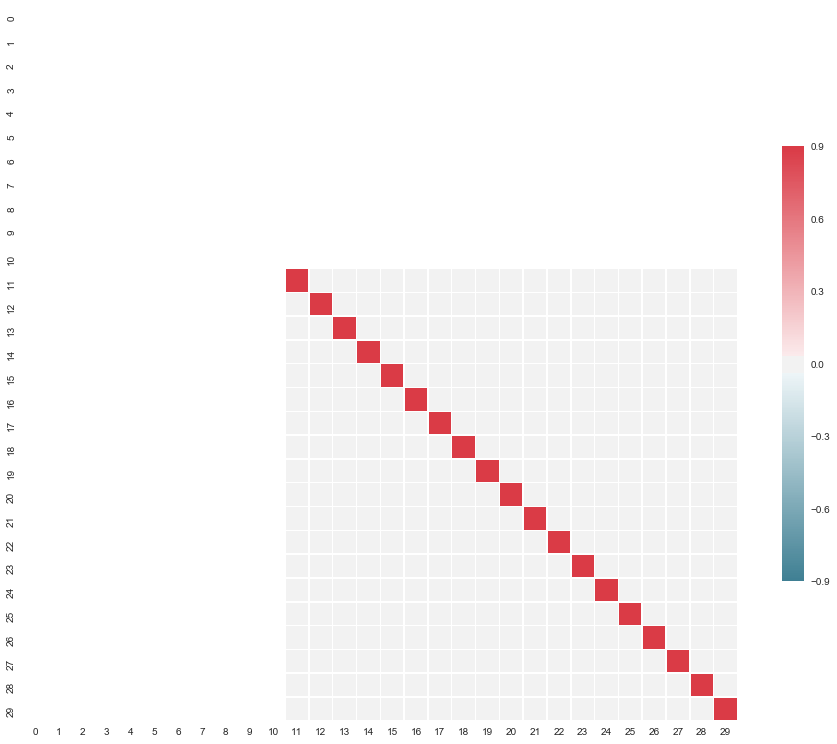

In [14]:
corr_heat_map(df_train, 0.9)

# XGB Cross Validation

In [23]:
%%time

print('formating for xgb')
d_train = xgb.DMatrix(df_train, label = labels)

formating for xgb
CPU times: user 9.68 s, sys: 12.7 s, total: 22.3 s
Wall time: 25.4 s


In [4]:
# eta = [0.1]
params = {
  "objective"           : "reg:logistic",
  "eval_metric"         : "auc",
  "eta"                 : 0.2,
  "max_depth"           : 6,
  "min_child_weight"    : 10,
  "gamma"               : 0.70,
  "subsample"           : 0.76,
  "colsample_bytree"    : 0.95,
  "alpha"               : 2e-05,
  "lambda"              : 10
}
ROUNDS = 200

In [5]:
%%time
xgb_cv = xgb.cv(params, \
                d_train, \
                ROUNDS, \
                nfold = 3, \
                stratified = True, \
                metrics = 'logloss', \
                early_stopping_rounds = 10, \
                verbose_eval = 10)

xgb_cv.tail()

[0]	train-logloss:0.57466+8.60233e-06	test-logloss:0.57467+2.00721e-05
[10]	train-logloss:0.313568+6.2361e-06	test-logloss:0.313675+4.38254e-05
[20]	train-logloss:0.303917+2.78209e-05	test-logloss:0.304137+3.09121e-05
[30]	train-logloss:0.303201+1.50628e-05	test-logloss:0.303551+5.3897e-05
[40]	train-logloss:0.302919+1.47271e-05	test-logloss:0.303397+5.26392e-05
[50]	train-logloss:0.302687+3.0663e-05	test-logloss:0.303281+4.04228e-05
[60]	train-logloss:0.302477+1.2083e-05	test-logloss:0.303187+2.77969e-05
[70]	train-logloss:0.302296+1.22293e-05	test-logloss:0.303109+2.10132e-05
[80]	train-logloss:0.302134+1.64384e-05	test-logloss:0.303059+1.38804e-05
[90]	train-logloss:0.30198+9.74109e-06	test-logloss:0.303017+1.62138e-05
[100]	train-logloss:0.301829+7.78888e-06	test-logloss:0.302974+1.65193e-05
[110]	train-logloss:0.301687+1.13137e-05	test-logloss:0.302937+9.62635e-06
[120]	train-logloss:0.30155+7.58654e-06	test-logloss:0.302902+1.92007e-05
[130]	train-logloss:0.30142+1.07083e-05	test

In [6]:
xgb_cv.tail()

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
195,0.302740,0.000015,0.300600,0.000007
196,0.302738,0.000017,0.300587,0.000007
197,0.302738,0.000016,0.300574,0.000007
198,0.302738,0.000018,0.300565,0.000009
199,0.302737,0.000018,0.300553,0.000010


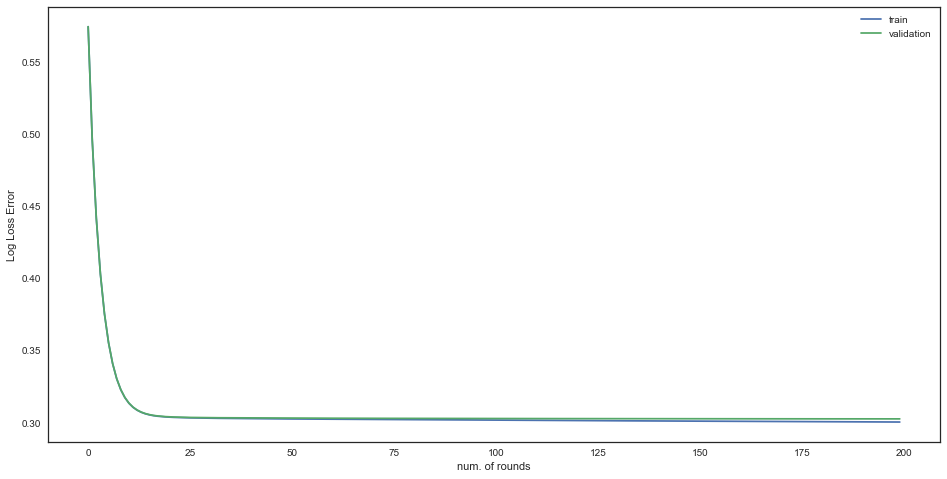

In [7]:
plt.figure(figsize=(16,8))
plt.plot(xgb_cv['train-logloss-mean'], label='train')
plt.plot(xgb_cv['test-logloss-mean'], label='validation')
# plt.xlim(200, 400)
# plt.ylim(0.3, 0.38)
plt.xlabel('num. of rounds')
plt.ylabel('Log Loss Error')
plt.legend()
plt.show()

# XGB Train

In [22]:
# Old
params = {
  "objective"           : "reg:logistic",
  "eval_metric"         : "auc",
  "eta"                 : 0.2,
  "max_depth"           : 6,
  "min_child_weight"    : 10,
  "gamma"               : 0.70,
  "subsample"           : 0.76,
  "colsample_bytree"    : 0.95,
  "alpha"               : 2e-05,
  "lambda"              : 10
}

# New
# params = {
#   "objective"           : "reg:logistic",
#   "eval_metric"         : "auc",
#   "eta"                 : 0.1,
#   "max_depth"           : 5,
#   "min_child_weight"    : 10,
#   "gamma"               : 0,
#   "subsample"           : 1,
#   "colsample_bytree"    : 1,
#   "base_score"          : 0.2
# }
ROUNDS = 5000

In [90]:
print('XGB train...')
n_folds = 5
skf = StratifiedKFold(n_splits = n_folds, random_state=None, shuffle=False)
fold_count = 0
for train_index, val_index in skf.split(df_train, labels):
    X_train, X_val = df_train.iloc[train_index, :], df_train.iloc[val_index, :]
    y_train, y_val = labels[train_index], labels[val_index]

#     print('formating for xgb')
#     d_train = xgb.DMatrix(X_train, label = y_train)
#     d_valid = xgb.DMatrix(X_val, label = y_val)
#     watchlist = [(d_train, 'train'), (d_valid, 'val')]

#     print('Training...')
#     bst = xgb.train(params = params, \
#                     dtrain = d_train, \
#                     num_boost_round = ROUNDS, \
#                     evals = watchlist, \
#                     verbose_eval = 10, \
#                     early_stopping_rounds = 50)
    d_val = xgb.DMatrix(X_val)
    pred_val = bst.predict(d_val)

#     Save the fold output:
#     pd.DataFrame(pred_val).to_csv('./xgb_train_fold_{}.csv'.format(fold_count))
#     pd.DataFrame(y_val).to_csv('./y_val_fold_{}.csv'.format(fold_count))

    fold_count += 1
    break

# new_param: 40 feats
# [555]	train-auc:0.839022	val-auc:0.836159

# old_param: 40 feats. Early_stop=15
# [190]	train-auc:0.839842	val-auc:0.836117
# [200]	train-auc:0.840078	val-auc:0.836112
# [210]	train-auc:0.840315	val-auc:0.836108
# [220]	train-auc:0.840564	val-auc:0.836095
# [230]	train-auc:0.840791	val-auc:0.836066
# [240]	train-auc:0.841022	val-auc:0.836055
# Stopping. Best iteration:
# [194]	train-auc:0.839939	val-auc:0.836128

# old_param: 40 features. Early_stop=50
# [360]	train-auc:0.837578	val-auc:0.830371
# [370]	train-auc:0.837784	val-auc:0.830384
# [380]	train-auc:0.837982	val-auc:0.830405
# [390]	train-auc:0.838165	val-auc:0.830431
# [400]	train-auc:0.838362	val-auc:0.830448
# [410]	train-auc:0.83857	val-auc:0.83048
# [420]	train-auc:0.83874	val-auc:0.830482
# [430]	train-auc:0.838954	val-auc:0.830528
# [440]	train-auc:0.839151	val-auc:0.830533
# [450]	train-auc:0.839347	val-auc:0.830548
# [460]	train-auc:0.839541	val-auc:0.830551
# [470]	train-auc:0.839736	val-auc:0.830555
# [480]	train-auc:0.839925	val-auc:0.830543
# [490]	train-auc:0.840117	val-auc:0.830551
# [500]	train-auc:0.840313	val-auc:0.83055
# [510]	train-auc:0.840489	val-auc:0.830545
# Stopping. Best iteration:
# [466]	train-auc:0.839653	val-auc:0.830562

# new_param: 38 feats
# [800]	train-auc:0.840565	val-auc:0.836048
# [810]	train-auc:0.840627	val-auc:0.836047
# [820]	train-auc:0.840688	val-auc:0.836044
# [830]	train-auc:0.840757	val-auc:0.836045
# [840]	train-auc:0.840813	val-auc:0.836043
# [850]	train-auc:0.840875	val-auc:0.83604
# Stopping. Best iteration:
# [806]	train-auc:0.8406	val-auc:0.83605

XGB train...


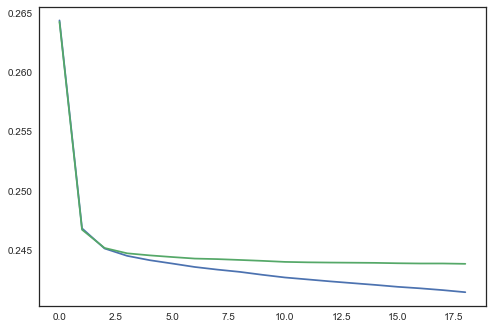

In [38]:
t = [0.264392, 0.246816, 0.245114, 0.244493, 0.244126, 0.243843, 0.243552, 0.243331, 0.243138, 0.242891, 0.242665, 0.242501, 0.242337, 0.242187, 0.242039, 0.241876, 0.241748, 0.241597, 0.24142]
v = [0.264268, 0.246703, 0.245158, 0.244708, 0.244534, 0.244393, 0.244263, 0.244218, 0.244146, 0.24407, 0.243982, 0.243946, 0.243927, 0.243914, 0.2439, 0.243868, 0.243848, 0.243848, 0.243818]
plt.figure(figsize=(16, 8))
plt.plot(range(0,19), t)
plt.plot(range(0,19), v)

In [24]:
# Save XGB model.
stamp = ''
for i, item in enumerate(list(params.values())):
    if i == 0:
        stamp = '_fold' + str(n_folds) + '_round' + str(466)
        continue
    else:
        stamp += '_' + str(item)
print('xgb{}_pca19'.format(stamp))
bst.save_model('xgb{}_pca19'.format(stamp))

xgb_fold5_round466_auc_0.2_6_10_0.7_0.76_0.95_2e-05_10_pca19


### Cross Validate the threshold

In [139]:
def multilabel_fscore(y_true, y_pred):
    """
    ex1:
    y_true = [1, 2, 3]
    y_pred = [2, 3]
    return: 0.8
    
    ex2:
    y_true = ["None"]
    y_pred = [2, "None"]
    return: 0.666
    
    ex3:
    y_true = [4, 5, 6, 7]
    y_pred = [2, 4, 8, 9]
    return: 0.25
    
    """
    y_true, y_pred = set(y_true), set(y_pred)
    
    precision = sum([1 for i in y_pred if i in y_true]) / len(y_pred)
    
    recall = sum([1 for i in y_true if i in y_pred]) / len(y_true)
    
    if precision + recall == 0:
        return 0
    return (2 * precision * recall) / (precision + recall)

In [140]:
# df_train['order_id'] = order_id
# df_train['product_id'] = product_id
df_val = df_train.iloc[val_index, :]
df_val['order_id'] = order_id[val_index]
df_val['product_id'] = product_id[val_index]
df_val.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(1694933, 42)

In [141]:
# Get true value.

y_true = df_val[y_val == 1].groupby('order_id')['product_id'].apply(list)
order_id_dict = dict()
for order in y_true.index:
    order_id_dict[order] = 1

print(y_true.shape, len(order_id_dict))
y_true.head()

(24535,) 24535


order_id
96                    [40706, 24489, 27966, 20574, 39275]
774                                        [16108, 43335]
844      [28289, 14992, 31766, 21405, 18599, 9387, 11182]
988                                                [4818]
1042    [24852, 23094, 28985, 10814, 35140, 16083, 33000]
Name: product_id, dtype: object

In [142]:
# Cross_Val to tune the threshold here.

# df_val = df_val.drop('pred', axis=1) # Drop 'pred' if already have 'pred' column
range_ = np.arange(0.18, 0.19, 0.01)
range_ = [0.18]
th_list = np.zeros(len(range_))
f1_list = np.zeros(len(range_))
for i, th in enumerate(range_):
    print('Threshold:', th)
    df_val['pred'] = pred_val
    temp_d = dict()
    order_id_list = []
    product_id_list = []
    for row in df_val.itertuples():
        if row.order_id in order_id_dict and row.pred > th:
            order_id_list.append(row.order_id)
            product_id_list.append(row.product_id)
            temp_d[row.order_id] = 1


    for order in order_id_dict:
        if order not in temp_d:
            order_id_list.append(order)
            product_id_list.append('None')

    y_pred = pd.DataFrame(data={'order_id': order_id_list, 'product_id': product_id_list})
    y_pred = y_pred.groupby('order_id')['product_id'].apply(list)
    del temp_d, order_id_list, product_id_list

    # Calculate mean F1 score:
    score = list(map(multilabel_fscore, y_true, y_pred))
    print(np.sum(score) / len(y_true), '\n')
    th_list[i] = th
    f1_list[i] = np.sum(score) / len(y_true)

Threshold: 0.18


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


0.396012669668 



0.18 : 0.396012669668


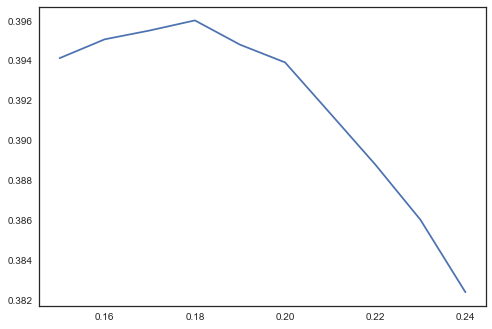

In [77]:
# Without PCA: 40 features

print(th_list[pd.Series(f1_list).idxmax()], ':',max(f1_list))
_ = plt.plot(th_list, f1_list)

#### Order Size Prediction

In [144]:
### Get the rmse of order_size, use this as baseline ###

# Get the order size of each order_id for y_true:
y_true = pd.DataFrame(y_true)

def row_size(row):
    return len(row)

y_true['order_size'] = y_true['product_id'].apply(row_size)
print(y_true.shape)

# Same thing for y_pred:
y_pred = pd.DataFrame(y_pred)

def row_size(row):
    return len(row)

y_pred['order_size'] = y_pred['product_id'].apply(row_size)
print(y_pred.shape)

(24535, 2)
(24535, 2)


In [158]:
y_true.head(), y_pred.head()

(                                                 product_id  order_size
 order_id                                                               
 96                      [40706, 24489, 27966, 20574, 39275]           5
 774                                          [16108, 43335]           2
 844        [28289, 14992, 31766, 21405, 18599, 9387, 11182]           7
 988                                                  [4818]           1
 1042      [24852, 23094, 28985, 10814, 35140, 16083, 33000]           7,
                                                  product_id  order_size
 order_id                                                               
 96                      [29603, 24489, 27966, 32578, 20574]           5
 774                                          [43739, 18394]           2
 844                     [14992, 42265, 25890, 11182, 33120]           5
 988       [13866, 41539, 25706, 41131, 5422, 41276, 3110...          10
 1042      [24964, 26629, 21137, 30482, 24852, 229

7.31939254546
5.02066435704


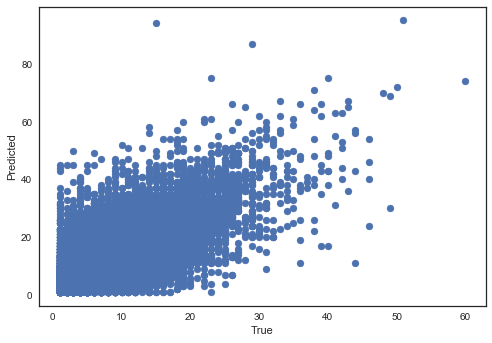

In [149]:
print(mean_squared_error(y_true['order_size'], y_pred['order_size'])**0.5)
print(mean_absolute_error(y_true['order_size'], y_pred['order_size']))
# threshold = 0.19
# RMSE = 6.77389648043
# MAE = 4.60301609945


_ = plt.scatter(y_true['order_size'], y_pred['order_size'])
_ = plt.xlabel('True')
_ = plt.ylabel('Predicted')

#### Using model to predict order size. See if this is better than threshold method.

In [151]:
order_id_val = pd.DataFrame(list(order_id_dict.keys()))
order_id_val.columns = ['order_id']
order_id_val = order_id_val.merge(usersXorders, how='left', on='order_id')

order_id_val_user_id = order_id_val['user_id']
order_id_val_order_id = order_id_val['order_id']
order_size = order_id_val['order_size']
order_id_val = order_id_val.drop(['user_id', 'order_id', 'order_size'], axis=1)
print(order_id_val.shape)
order_id_val.head()

(24535, 9)


,order_number,order_dow,order_hour_of_day,days_since_prior_order,average_days_between_orders,nb_orders,total_items,total_distinct_items,average_basket
0,7,6,20,30.0,21.000000,7,43,33,6.142857
1,25,0,17,12.0,13.958333,25,146,94,5.840000
2,10,6,15,11.0,25.000000,10,54,35,5.400000
3,100,2,9,4.0,3.333333,100,493,142,4.930000
4,10,1,17,30.0,27.666666,10,105,44,10.500000


In [162]:
# Load order size model

bst = xgb.Booster()
bst.load_model('./xgb_order_size')
pred_order_size = bst.predict(xgb.DMatrix(order_id_val))
pred_order_size = np.round(pred_order_size)
print(pred_order_size.shape)

pred_order_size = pd.DataFrame(data={'order_id':order_id_val_order_id , 'order_size':pred_order_size})
pred_order_size['order_size'] = pred_order_size['order_size'].astype(int)
pred_order_size.head()

(24535,)


,order_id,order_size
0,96,7
1,774,7
2,844,6
3,988,6
4,1042,12


6.10854870084
4.6668840432


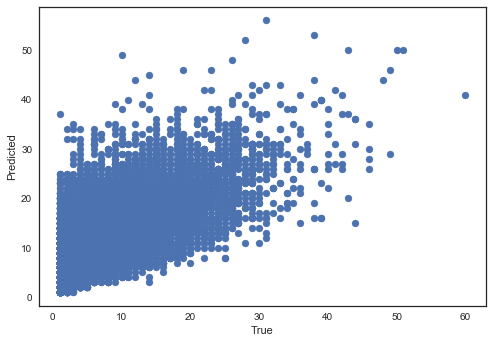

In [163]:
print(mean_squared_error(y_true['order_size'], pred_order_size['order_size'])**0.5)
print(mean_absolute_error(y_true['order_size'], pred_order_size['order_size']))
# RMSE = 6.10854870084
# MAE = 4.6668840432


_ = plt.scatter(y_true['order_size'], pred_order_size['order_size'])
_ = plt.xlabel('True')
_ = plt.ylabel('Predicted')

# XGB Predict

In [59]:
# Join Data.

print('Loading dataframes...')
r_test = pd.read_csv(IDIR + 'r_test_maxRank.csv').drop('Unnamed: 0', axis=1)
r_test['ord_prod_id_r'] = r_test['order_id'] * 100000 + r_test['product_id']
r_test = r_test.add_prefix('r_')
print(r_test.columns)

df_test = pd.read_csv(IDIR + 'df_test_feats_40.csv')
df_test['ord_prod_id'] = df_test['order_id'] * 100000 + df_test['product_id']
print(df_test.shape)

print('Join features together...')
df_test = pd.merge(df_test, r_test, how='left', left_on='ord_prod_id', right_on='r_ord_prod_id_r', suffixes=('', '_r'))
df_test.to_csv('./df_test_feats_40.csv', index=False)
print(df_test.shape)
del r_test

Loading dataframes...
(4833292, 49)


,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,r_user_distinct_products,r_user_average_basket,r_order_id,r_eval_set,r_time_since_last_order,r_up_order_rate,r_up_orders_since_last_order,r_up_order_rate_since_first_order,r_reordered,r_ord_prod_id_r
0,2774568,17668,13,88,33,12.0,6.769231,15,11.0,0.916667,...,33,7.333333,2774568,test,11,0.416667,1,0.416667,NaN,277456817668
1,2774568,44683,13,88,33,12.0,6.769231,15,11.0,0.916667,...,33,7.333333,2774568,test,11,0.166667,6,0.250000,NaN,277456844683
2,2774568,48523,13,88,33,12.0,6.769231,15,11.0,0.916667,...,33,7.333333,2774568,test,11,0.166667,3,0.400000,NaN,277456848523
3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,0.916667,...,33,7.333333,2774568,test,11,0.666667,0,0.666667,NaN,277456821903
4,2774568,14992,13,88,33,12.0,6.769231,15,11.0,0.916667,...,33,7.333333,2774568,test,11,0.166667,5,0.285714,NaN,277456814992


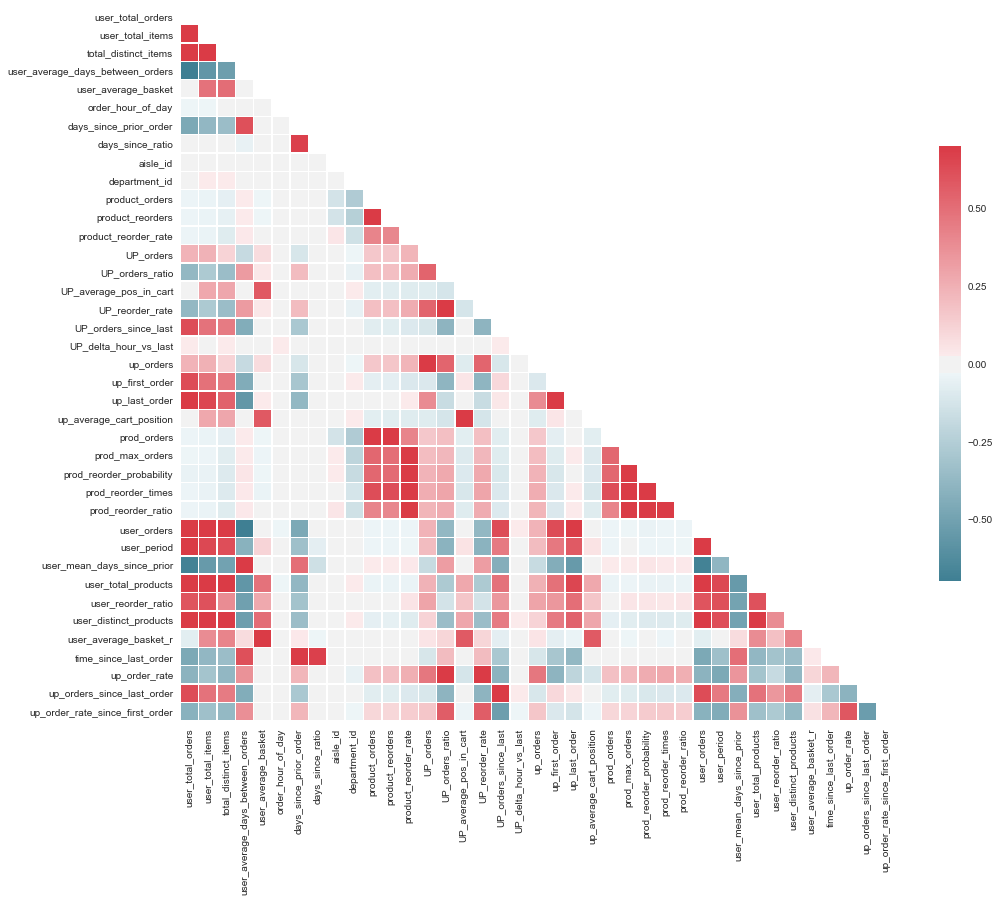

In [16]:
corr_heat_map(df_test, 0.9)

In [89]:
# Load Model
bst = xgb.Booster()
bst.load_model('./models/xgb_fold5_round806_auc_0.1_5_10_0_1_1_0.2_feats40')

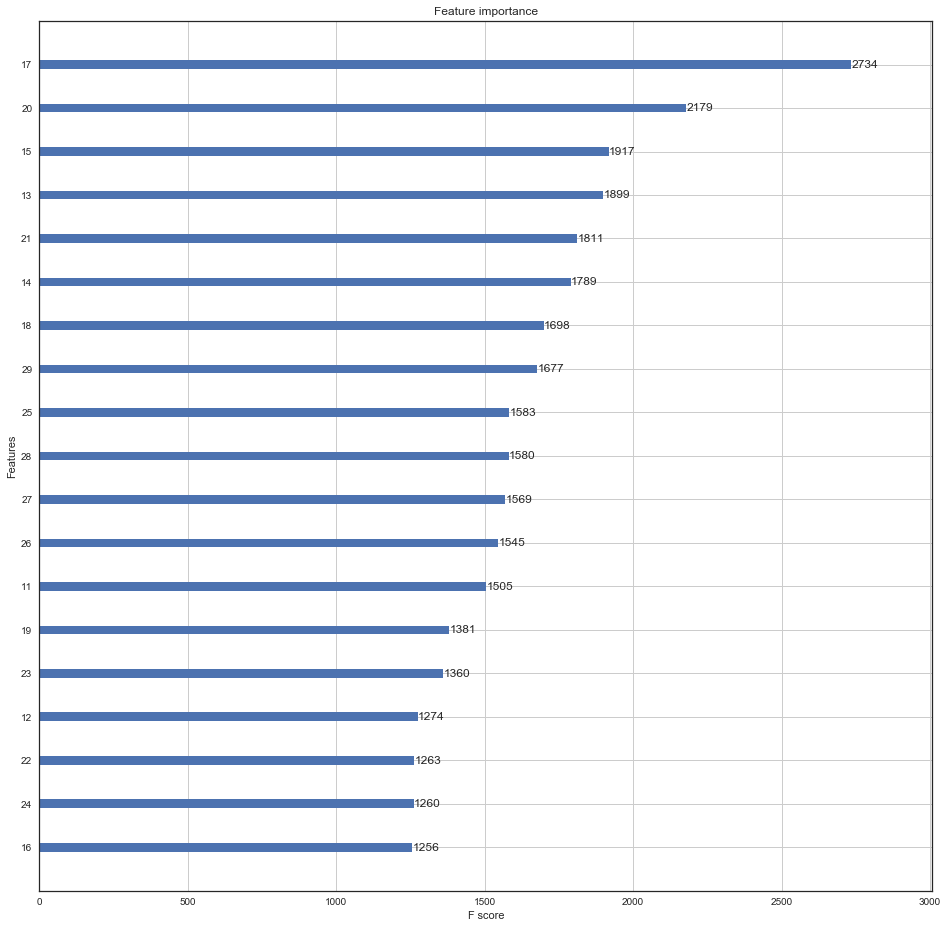

In [50]:
plt.rcParams["figure.figsize"] = (16, 16)
_ = xgb.plot_importance(bst)

In [62]:
pred = pd.DataFrame(bst.predict(xgb.DMatrix(df_test)))
print(pred.shape)
pred.head()

(4833292, 1)


,0
0,0.457502
1,0.135260
2,0.149176
3,0.696963
4,0.125063


In [63]:
df_test['order_id'] = test_order_id
df_test['product_id'] = test_product_id
del test_order_id, test_product_id
gc.collect()

11425

In [67]:
%%time

df_test['pred'] = pred
TRESHOLD = 0.20
# Guess, should be tuned with crossval on a subset of train data
# [0.21=0.22:0.3803346 || 0.25:0.3753030 || 0.19:0.3808674 || 0.15:0.3742407 || 0.17:0.3787476]
# [0.15, 0.17, 0.19, 0.21, 0.22, 0.25]
# [0.3742407, 0.3787476, 0.3808674, 0.3803346, 0.3803346, 0.3753030]

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

# Get test_orders with order_id
orders = pd.read_csv('../../data/orders.csv')
test_orders = orders[orders.eval_set == 'test']
del orders

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

del test_orders

CPU times: user 20.7 s, sys: 308 ms, total: 21 s
Wall time: 21 s


In [68]:
sub = pd.DataFrame.from_dict(d, orient='index')
print(sub.shape)
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

(75000, 1)


In [69]:
sub.head(10)

,order_id,products
0,2774568,17668 21903 32402 39190 47766 16797 18599 4396...
1,329954,21573 17769 35469 37646 1200 19057 26576 2707 ...
2,1528013,40992 27521 20323 48679 8424 45007 21903 10644...
3,1376945,33572 27959 44632 14947 8309 13176
4,1356845,14992 30489 7076 20144 10863 13176
5,2161313,11266 196 10441 12427 37710 48142 1747 14715 2...
6,1416320,28289 5134 21903 21137 24852 48283 17948 32691...
7,1735923,17008
8,1980631,13575 6184 9387 46061 13914 41400 22362
9,139655,39040 17794 24964 7948 21903 32655 35221 22935...


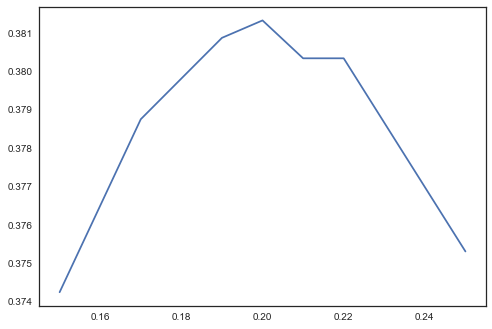

In [61]:
# 40 feats with maxRank & interval feats:
# [0.19, 0.20, 0.205, 0.21]
# [0.3811821. 0.3812778, 0.3809507, 0.3809003]

# 39 feats with maxRank feat:
# [0.20]
# [0.3800656]

# 39 features with interval feat:
# x_ = [0.18, 0.20, 0.22]
# y_ = [0.3798229, 0.3806497, 0.3795305]

# 38 features:
x_ = [0.15, 0.17, 0.19, 0.20, 0.21, 0.22, 0.25]
y_ = [0.3742407, 0.3787476, 0.3808674, 0.3813217, 0.3803346, 0.3803346, 0.3753030]
_ = plt.plot(x_, y_)

# Feature Engineering

In [25]:
IDIR = '../../data/'
print('loading prior')
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading train')
train = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv(IDIR + 'products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])

print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
# print('products {}: {}'.format(products.shape, ', '.join(products.columns)))

loading prior
loading train
loading orders
loading products
priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order


In [26]:
print('computing product f')
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32) # No. of items of each product_id group. How many times this item has been ordered.
prods['reorders'] = priors.groupby('product_id')['reordered'].sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods
print(gc.garbage)
print(gc.collect())
print(gc.garbage)

products.head()

computing product f
[]
[]


,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,1852.0,1136.0,0.613391
2,2,104,13,90.0,12.0,0.133333
3,3,94,7,277.0,203.0,0.732852
4,4,38,1,329.0,147.0,0.446809
5,5,5,13,15.0,9.0,0.600000


In [27]:
print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)

# Adding cols. from orders to priors, will make duplicates on each order_id
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)
priors.head()

add order info to priors


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [28]:
### user related features ###

print('computing user f')
users = pd.DataFrame()
users['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
users['nb_orders'] = orders.groupby('user_id').size().astype(np.int16) # orders data gives user_id, order_id
users['total_items'] = priors.groupby('user_id').size().astype(np.int16) # priors data gives order_id, product_id
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users['all_products'].map(len)).astype(np.int16)
users['average_basket'] = (users['total_items'] / users['nb_orders']).astype(np.float32)
users['user_id'] = users.index
print('user f', users.shape)
users.head()

computing user f
user f (206209, 7)


,average_days_between_orders,nb_orders,total_items,all_products,total_distinct_items,average_basket,user_id
user_id,,,,,,,
1,19.000000,11,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,5.363636,1
2,16.285715,15,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,13.000000,2
3,12.000000,13,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,6.769231,3
4,17.000000,6,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,3.000000,4
5,11.500000,5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,7.400000,5


In [29]:
### userXproduct features ###

print('compute userXproduct f - this is long...')
priors['user_product'] = priors.product_id + priors.user_id * 100000
priors.head()

compute userXproduct f - this is long...


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product
0,2,33120,1,1,202279,prior,3,5,9,8.0,-1246903360
1,2,28985,2,1,202279,prior,3,5,9,8.0,-1246907495
2,2,9327,3,0,202279,prior,3,5,9,8.0,-1246927153
3,2,45918,4,1,202279,prior,3,5,9,8.0,-1246890562
4,2,30035,5,0,202279,prior,3,5,9,8.0,-1246906445


In [61]:
#############################################################
### Just testing and visualizing how this dictionary work ###

temp = priors[priors['user_product'] == -1246903360]
d = dict()
for row in temp.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1, \
                (row.order_number, row.order_id), \
                row.add_to_cart_order, \
                [row.order_number])
    else:
        d[z] = (d[z][0] + 1, \
                max(d[z][1], (row.order_number, row.order_id)), \
                d[z][2] + row.add_to_cart_order, \
                sorted(d[z][3] + [row.order_number]))
print(d)

def get_avg_interval(list_):
    for i, item in enumerate(list_):
        if i == 0:
            diff = 0
            diff = item - 1
            last = item
        else:
            diff = diff + (item - last)
            last = item
    return diff / (i+1)

print(get_avg_interval(d[-1246903360][3]))
temp[['user_product', 'order_number', 'order_id', 'user_id', 'product_id', 'add_to_cart_order']].head()

### Just testing and visualizing how this dictionary work ###
#############################################################

{-1246903360: (5, (8, 104690), 10, [1, 3, 5, 6, 8])}
1.4


,user_product,order_number,order_id,user_id,product_id,add_to_cart_order
0,-1246903360,3,2,202279,33120,1
990781,-1246903360,8,104690,202279,33120,2
1254949,-1246903360,6,132412,202279,33120,1
26635932,-1246903360,5,2808715,202279,33120,1
27453973,-1246903360,1,2894949,202279,33120,5


In [30]:
%%time

# For each (user_id , product_id) pair, 
## count number of occurences of this pair
## get the latest order_id from max(order_number, order_id). Note: order_id is not sequential, order_number is.
## accumulate all add_to_cart_order

d = dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1, \
                (row.order_number, row.order_id), \
                row.add_to_cart_order, \
                [row.order_number])
    else:
        d[z] = (d[z][0] + 1, \
                max(d[z][1], (row.order_number, row.order_id)), \
                d[z][2] + row.add_to_cart_order, \
                sorted(d[z][3] + [row.order_number]))
print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.head()

to dataframe (less memory)
[]
0
[]
CPU times: user 5min 36s, sys: 7.68 s, total: 5min 44s
Wall time: 5min 49s


In [31]:
def get_avg_interval(list_):
    if len(list_) == 1:
        return list_[0]
    for i, item in enumerate(list_):
        if i == 0:
            diff = 0
            last = item
        else:
            diff = diff + (item - last)
            last = item
    return diff / (i+1)

userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart', 'order_num_list']
userXproduct['nb_orders'] = userXproduct['nb_orders'].astype(np.int16)
userXproduct['last_order_id'] = userXproduct['last_order_id'].map(lambda x: x[1]).astype(np.int32)
userXproduct['sum_pos_in_cart'] = userXproduct['sum_pos_in_cart'].astype(np.int16)
userXproduct['avg_order_gap'] = userXproduct['order_num_list'].map(get_avg_interval)

print('user X product f', len(userXproduct))
userXproduct.head(20)

user X product f 13293564


,nb_orders,last_order_id,sum_pos_in_cart,order_num_list,avg_order_gap
-1246903360,5,104690,10,"[1, 3, 5, 6, 8]",1.400000
-1246907495,5,132412,16,"[1, 2, 3, 5, 6]",1.000000
-1246927153,1,2,3,[3],3.000000
-1246890562,5,2382766,24,"[2, 3, 5, 6, 7]",1.000000
-1246906445,3,2382766,14,"[3, 5, 7]",1.333333
-1246918686,7,2382766,25,"[1, 2, 3, 4, 5, 6, 7]",0.857143
-1246896339,5,132412,29,"[2, 3, 4, 5, 6]",0.800000
-1246934661,2,2,19,"[2, 3]",0.500000
-1246892812,3,132412,20,"[3, 5, 6]",1.000000
-877802726,17,368699,86,"[1, 3, 4, 5, 6, 9, 10, 11, 14, 15, 16, 18, 20,...",1.411765


#### Note:
#### 1. Feature DataFrames: products, users, userXproduct
#### 2. DataFrames: train, orders, priors

In [ ]:
### train / test orders ###
print('split orders : train, test')
train_orders = orders[orders.eval_set == 'train']
# test_orders = orders[orders.eval_set == 'test']
# prior_orders = orders[orders.eval_set == 'prior']
train_orders.head()

# train.set_index(['order_id', 'product_id'], inplace=True, drop=False)
# priors.set_index(['order_id', 'product_id'], inplace=True, drop=False)

# For prior data feature engineering
## Get (order_id, product_id) pairs and its labels
### Step 1: get priors <- just products_prior is enough, or join products_prior with orders on user_id
#### Step 1.1: Create (order_id * 10000000000 + product_id) column as unique_id
### Step 2: get prior_orders <- orders filter eval_set == 'prior'
#### Step 2.1: Merge with users df, stack() to create a new df with (order_id, product_id) pair
#### Step 2.2: Create (order_id * 10000000000 + product_id) column as unique_id
### Step 3: Merge new_idf with priors on the unique_id column to get (order_id, product_id, reordered)

In [ ]:
def create_df(i_current):
    print('create_df function at range {}'.format(i_current))
    df = prior_orders.merge(users, how='left', on='user_id', suffixes=('', '_u'))
    df = df[['order_id', 'all_products']]
    s = df.apply(lambda x: pd.Series(list(x['all_products'])), axis=1).stack().reset_index(level=1, drop=True)
    s = s[s != '{']
    s = s[s != '}']
    s = s[s != ',']
    s = s[s != ' ']
    s = s.astype(int)
    s.name = 'product_id'
    df = df.drop('all_products', axis=1).join(s)
    df['z'] = (df['order_id'] * 10000000000) + df['product_id']
    del s

    priors['z'] = (priors['order_id'] * 10000000000) + priors['product_id']
    df = df.merge(priors, how='left', on='z', suffixes=('', '_r'))
    df = df[['order_id', 'product_id', 'reordered']]
    df.to_csv('./prior_train_{}.csv'.format(i_current))


# prior_orders.shape = 3,214,874
priors = pd.read_csv('../../data/order_products__prior.csv', dtype={
    'order_id': np.int32,
    'product_id': np.uint16,
    'add_to_cart_order': np.int16,
    'reordered': np.int8})
users = pd.read_csv('users.csv').drop('user_id.1', axis=1)
users.head()
i_past = int()
for i in range(0, 3214874, 100000):
    start_time = time.time()
    print('Range: {} to {}'.format(i_past, i))
    if i == 0:
        i_past = i
        continue
    else:
        prior_orders = pd.read_csv('prior_orders.csv')[i_past:i]
        create_df(i_past)
        i_past = i
    if i_past == 3200000:
        prior_orders = pd.read_csv('prior_orders.csv')[i_past:]
        create_df(i_past)
    print('Time: ', time.time() - start_time)

In [11]:
######################################################################
### Directly loading prior_train (order_id, product_id, reordered) ###
######################################################################

# df = pd.DataFrame()
# # 3214874
# for i in range(0, 600000, 100000):
#     if i == 0:
#         df = pd.read_csv('./prior_train/prior_train_{}.csv'.format(i)).drop('Unnamed: 0', axis=1)
#     else:
#         df = pd.concat([df, pd.read_csv('./prior_train/prior_train_{}.csv'.format(i)).drop('Unnamed: 0', axis=1)])

# 828,824 (train_order)
# 13384 (prior_order)
print(df.shape)
print(np.sum(df['reordered']==1.))
print(np.sum(df['reordered']==0.))
df.head()

(301605489, 3)
13384
10162


,order_id,product_id,reordered
0,2539329,1,NaN
1,2539329,7,NaN
2,2539329,1,NaN
3,2539329,2,NaN
4,2539329,2,NaN


In [ ]:
# Same as above for train_orders
def create_df(i_current):
    print('create_df function at range {}'.format(i_current))
    df = train_orders.merge(users, how='left', on='user_id', suffixes=('', '_u'))
    df = df[['order_id', 'all_products']]
    s = df.apply(lambda x: pd.Series(list(x['all_products'])), axis=1).stack().reset_index(level=1, drop=True)
    s = s[s != '{']
    s = s[s != '}']
    s = s[s != ',']
    s = s[s != ' ']
    s = s.astype(int)
    s.name = 'product_id'
    df = df.drop('all_products', axis=1).join(s)
    df['z'] = (df['order_id'] * 10000000000) + df['product_id']
    del s

    priors['z'] = (priors['order_id'] * 100s00000000) + priors['product_id']
    df = df.merge(priors, how='left', on='z', suffixes=('', '_r'))
    df = df[['order_id', 'product_id', 'reordered']]
    df.to_csv('./train_df_{}.csv'.format(i_current))


train = pd.read_csv('../../data/order_products__train.csv', dtype={
    'order_id': np.int32,
    'product_id': np.uint16,
    'add_to_cart_order': np.int16,
    'reordered': np.int8})
users = pd.read_csv('users.csv').drop('user_id.1', axis=1)
users.head()
create_df('new')
print('Time: ', time.time() - start_time)

In [ ]:
print('user related features')
df['user_id'] = df.order_id.map(orders.user_id)
df['user_total_orders'] = df.user_id.map(users.nb_orders)
df['user_total_items'] = df.user_id.map(users.total_items)
df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
df['user_average_basket'] =  df.user_id.map(users.average_basket)

print('order related features')
df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders

print('product related features')
df['aisle_id'] = df.product_id.map(products.aisle_id)
df['department_id'] = df.product_id.map(products.department_id)
df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
df['product_reorders'] = df.product_id.map(products.reorders)
df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

print('user_X_product related features')
df['z'] = df.user_id * 100000 + df.product_id
df.drop(['user_id'], axis=1, inplace=True)
df['UP_avg_order_gap'] = df.z.map(userXproduct.avg_order_gap)
df['UP_orders'] = df.z.map(userXproduct.nb_orders)
df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number) # User total orders - UxP.order_id.order_number
df['UP_delta_orders_vs_last'] = df['UP_orders_since_last'] - df['UP_avg_order_gap']

# (Current_order_hour_of_day) - (Last_order_hour_of_day). The time of day diff between current_order & last_order.
## i.e. Last time this product was ordered at 3PM by this user, this time it's ordered at 4PM, so 1 hour apart.
## The closer the hours, the smaller this feature, higher probability it will be re-ordered.
df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)) \
                                                                  .map(lambda x: min(x, 24-x)).astype(np.int8)

# df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
#                                                                      df.order_id.map(orders.order_dow)

df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
print(df.dtypes)
print(df.memory_usage())

user related features


In [74]:
df.to_csv('./df_train_interval.csv', index=False)
pd.DataFrame(labels).to_csv('./labels_train_interval.csv', index=False) # No labels for test set.

9.22492229955


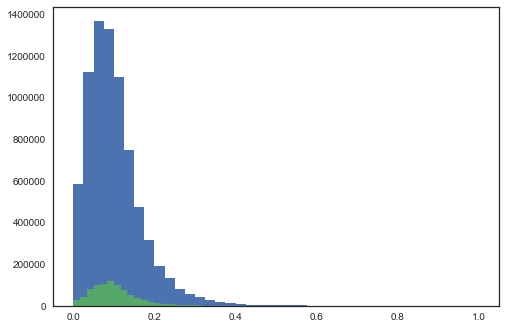

In [117]:
# Plotting to see predictability of the feature.
df['labels'] = labels

H1 = df[df['labels'] == 1]['days_since_ratio']
newH1 = H1[~np.isnan(H1)]
norm1 = np.apply_along_axis(func1d=lambda x: x/np.max(newH1), arr=newH1, axis=0)

H0 = df[df['labels'] == 0]['days_since_ratio']
newH0 = H0[~np.isnan(H0)]
norm0 = np.apply_along_axis(func1d=lambda x: x/np.max(newH0), arr=newH0, axis=0)

print(np.sum([df['labels'] == 0]) / np.sum([df['labels'] == 1]))
_ = plt.hist(norm0, bins=40)
_ = plt.hist(norm1, bins=60)

### Function for feature engineering

In [ ]:
### Build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    ''' Builds (order_id, product_id) pairs. 
    The order_id is repeated until all associated product_id is looped through. 
    Every order_id has several associated product_id & a unique user_id. '''

    print('build candidate list')
#     order_list = []
#     product_list = []
#     labels = []
#     i=0
#     for row in selected_orders.itertuples():
#         i += 1
#         if i%10000 == 0: print('order row:', i, '/', len(selected_orders))
#         order_id = row.order_id
#         user_id = row.user_id
#         # users df contains all user_id; selected_orders df contains part of the user_id
#         user_products = users.all_products[user_id] # The index of users df is the user_id. All products the user ordered.
#         product_list += user_products
#         order_list += [order_id] * len(user_products)
#         if labels_given:
#             labels += [(order_id, product) in train.index for product in user_products]

#     df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
#     labels = np.array(labels, dtype=np.int8)
#     del order_list
#     del product_list

    df = prior_orders.merge(users, how='left', on='user_id', suffixes=('', '_u'))
    df = df[['order_id', 'all_products']]
    s = df.apply(lambda x: pd.Series(list(x['all_products'])), axis=1).stack().reset_index(level=1, drop=True)
    s = s[s != '{']
    s = s[s != '}']
    s = s[s != ',']
    s = s[s != ' ']
    s = s.astype(int)
    s.name = 'product_id'
    df = df.drop('all_products', axis=1).join(s)
    df['z'] = (df['order_id'] * 10000000000) + df['product_id']
    del s
    priors['z'] = (priors['order_id'] * 10000000000) + priors['product_id']
    df = df.merge(priors, how='left', on='z', suffixes=('', '_r'))
    df = df[['order_id', 'product_id', 'reordered']]
    df.to_csv('./prior_train_{}.csv'.format(i_current))

    
    # New methods to replace the above
    df = selected_orders.merge(users, how='left', on='user_id', suffixes=('', '_u'))
    df = df[['order_id', 'all_products', 'reordered']]
    s = df.apply(lambda x: pd.Series(list(x['all_products'])), axis=1).stack().reset_index(level=1, drop=True)
    s = s.astype(int)
    s.name = 'product_id'
    df = df.drop('all_products', axis=1).join(s)
    del s
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_avg_order_gap'] = df.z.map(userXproduct.avg_order_gap)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number) # User total orders - UxP.order_id.order_number
    df['UP_delta_orders_vs_last'] = df['UP_orders_since_last'] - df['UP_avg_order_gap']
    
    # (Current_order_hour_of_day) - (Last_order_hour_of_day). The time of day diff between current_order & last_order.
    ## i.e. Last time this product was ordered at 3PM by this user, this time it's ordered at 4PM, so 1 hour apart.
    ## The closer the hours, the smaller this feature, higher probability it will be re-ordered.
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)) \
                                                                      .map(lambda x: min(x, 24-x)).astype(np.int8)
    
    # df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                                                      df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

df_test, _ = features(test_orders, labels_given=False)
df_test.to_csv('./df_test_interval.csv', index=False)
df_test.head()